In [22]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET, omnifold
from of_transformer import block, embed, input_distributed, net_utils, of_transformer, pair_embed, sequence_trimmer 
import test_omnifold
import PET

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="0" # GPU Server Available: 0,1,2,3,4,5,6,7
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_ttbar_singletop_DR.pkl')

In [3]:
def MC_data_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    truth_pts  = [df[f'truth_pt{p}']   for p in particle_names]
    truth_etas = [df[f'truth_eta{p}']  for p in particle_names]
    truth_phis = [df[f'truth_phi{p}']  for p in particle_names]
    
    truth_masses = [np.zeros_like(df['truth_ptl1'])] + \
                   [df[f'truth_mb{i}'] for i in range(1, 5)] + \
                   [df[f'truth_mj{i}'] for i in range(1, 7)]

    truth_features = np.stack([truth_pts, truth_etas, truth_phis, truth_masses], axis=-1)
    truth_features = truth_features.transpose(1, 0, 2)

    # Neutrino (truth): use 'truth_met' and 'truth_met_phi'
    truth_met_pt = df['truth_met']
    truth_met_phi = df['truth_metphi']
    zeros_truth = np.zeros_like(truth_met_pt)
    neutrino_truth = np.stack([truth_met_pt, zeros_truth, truth_met_phi, zeros_truth], axis=-1)

    truth_features = np.concatenate([truth_features, neutrino_truth[:, None, :]], axis=1)
    
    return reco_features, truth_features

In [4]:
def subset(df, n_evts, train_test=False):
    
    random_subset = df.sample(n_evts, random_state=42)
    subset_fraction = n_evts / len(df)
    random_subset["eventWeight"] = random_subset['eventWeight'] / subset_fraction # Normalize

    if train_test:
        remaining_df = df.drop(random_subset.index)
        second_subset = remaining_df.sample(n_evts, random_state = 99)
        second_subset['eventWeight'] = second_subset['eventWeight'] / subset_fraction
        
        return random_subset, second_subset

    return random_subset

pythia_train, pythia_test = subset(pythia_df, 1_000_000, train_test=True)
herwig_subset = subset(herwig_df, 1_000_000, train_test=False)

pythia_reco_train, pythia_truth_train = MC_data_shaper(pythia_train)
pythia_reco_test, pythia_truth_test = MC_data_shaper(pythia_test)
herwig_reco, herwig_truth = MC_data_shaper(herwig_subset)

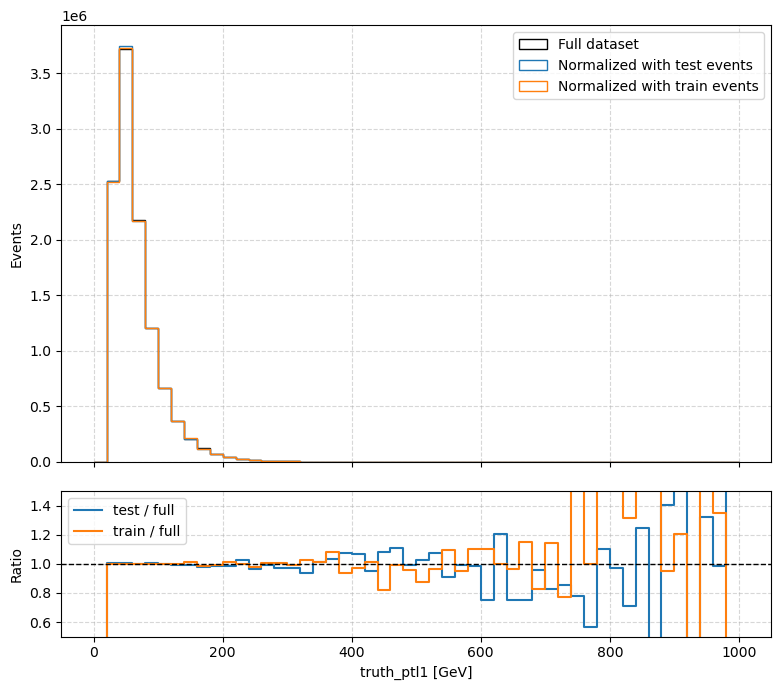

In [5]:
# --- Histogram settings ---
bins = 50
range_ = [0, 1000]

# --- Compute the histograms (shared binning) ---
ref_counts, bin_edges = np.histogram(
    pythia_df["truth_ptl1"], bins=bins, range=range_, weights=pythia_df["eventWeight"])
test_counts, _ = np.histogram(
    pythia_test["truth_ptl1"], bins=bins, range=range_, weights=pythia_test["eventWeight"])
train_counts, _ = np.histogram(
    pythia_train["truth_ptl1"], bins=bins, range=range_, weights=pythia_train["eventWeight"])

# --- Compute bin centers for plotting ---
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# --- Compute ratios relative to reference (pythia_df) ---
# avoid division by zero
ratio_test = np.divide(test_counts, ref_counts, out=np.zeros_like(test_counts), where=ref_counts != 0)
ratio_train = np.divide(train_counts, ref_counts, out=np.zeros_like(train_counts), where=ref_counts != 0)

# --- Create figure with two subplots (main + ratio) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# === Upper plot: main distributions ===
ax1.hist(
    bin_centers, bins=bin_edges, weights=ref_counts,
    histtype="step", label="Full dataset", color="black")
ax1.hist(
    bin_centers, bins=bin_edges, weights=test_counts,
    histtype="step", label="Normalized with test events")
ax1.hist(
    bin_centers, bins=bin_edges, weights=train_counts,
    histtype="step", label="Normalized with train events")
# ax1.set_yscale('log')
ax1.set_ylabel("Events")
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.5)

# === Lower plot: ratios ===
ax2.plot(bin_centers, ratio_test, drawstyle="steps-mid", label="test / full")
ax2.plot(bin_centers, ratio_train, drawstyle="steps-mid", label="train / full")
ax2.axhline(1.0, color="black", linestyle="--", linewidth=1)
ax2.set_xlabel("truth_ptl1 [GeV]")
ax2.set_ylabel("Ratio")
ax2.set_ylim(0.5,1.5)
ax2.grid(True, linestyle="--", alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()


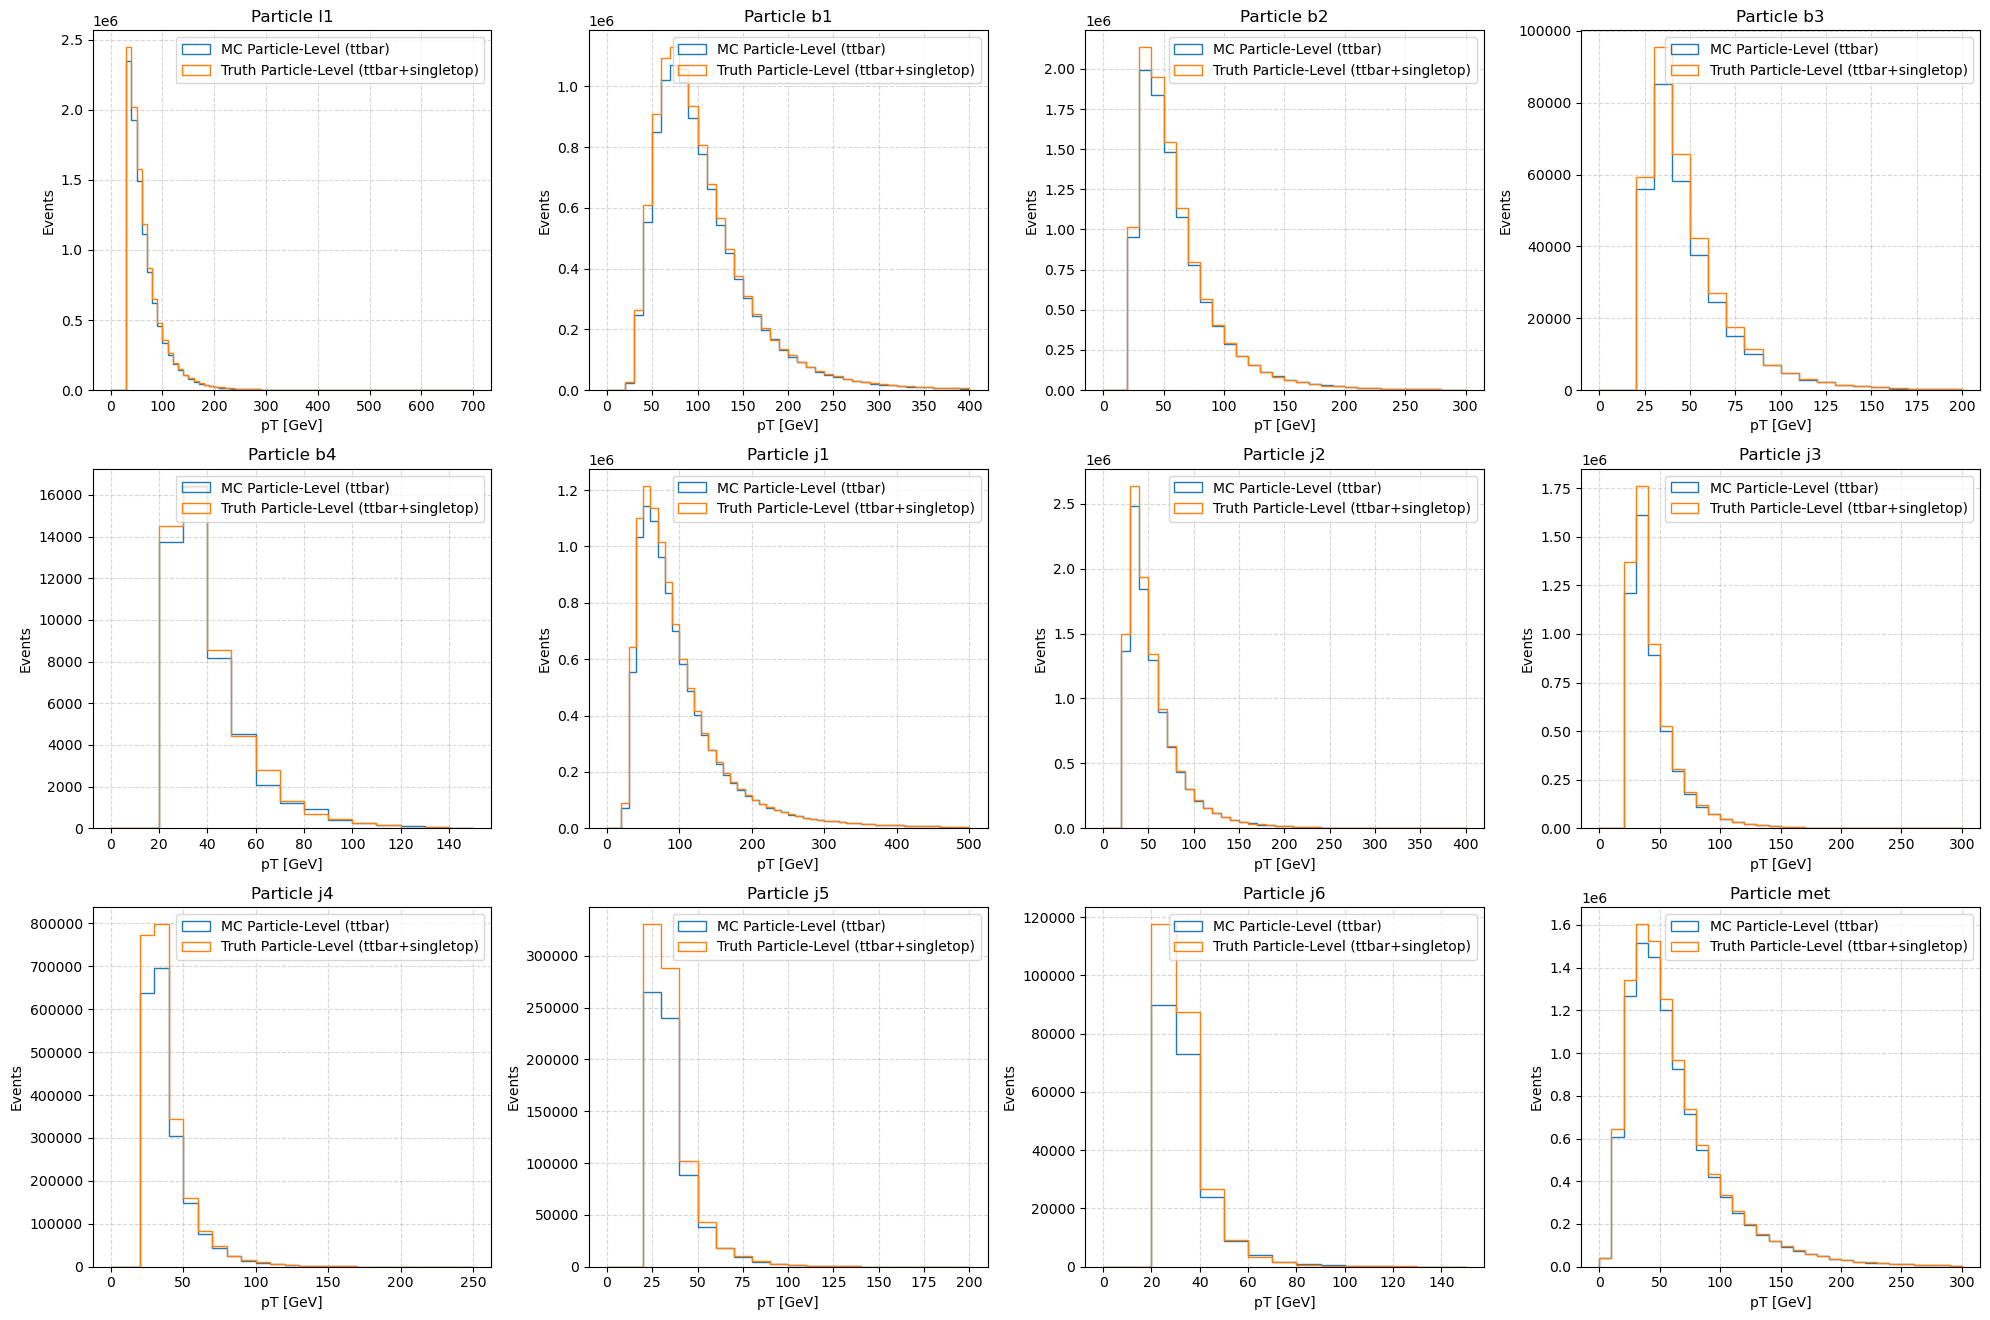

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']
pt_binning = {
    'l1': np.linspace(0, 700, 71),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
# --- Loop over all 12 particles ---
for i, pname in enumerate(particles):
    ax = axes[i]
    bins = pt_binning[pname]
    
    # masks for non-zero (non-padded) pT entries
    mask_pythia = pythia_truth_train[:, i, 0] != 0
    mask_herwig = herwig_truth[:, i, 0] != 0

    # Use .values[...] to align numpy masks with pandas Series
    ax.hist(
        pythia_truth_train[:, i, 0][mask_pythia],
        weights=(pythia_train['eventWeight'] * pythia_train['pass_particle'])[mask_pythia],
        bins=bins,
        histtype='step',
        label='MC Particle-Level (ttbar)'
    )
    ax.hist(
        herwig_truth[:, i, 0][mask_herwig],
        weights=(herwig_subset['eventWeight'] * herwig_subset['pass_particle'])[mask_herwig],
        bins=bins,
        histtype='step',
        label='Truth Particle-Level (ttbar+singletop)'
    )
    
    ax.set_title(f"Particle {pname}")
    ax.set_xlabel("pT [GeV]")
    ax.set_ylabel("Events")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

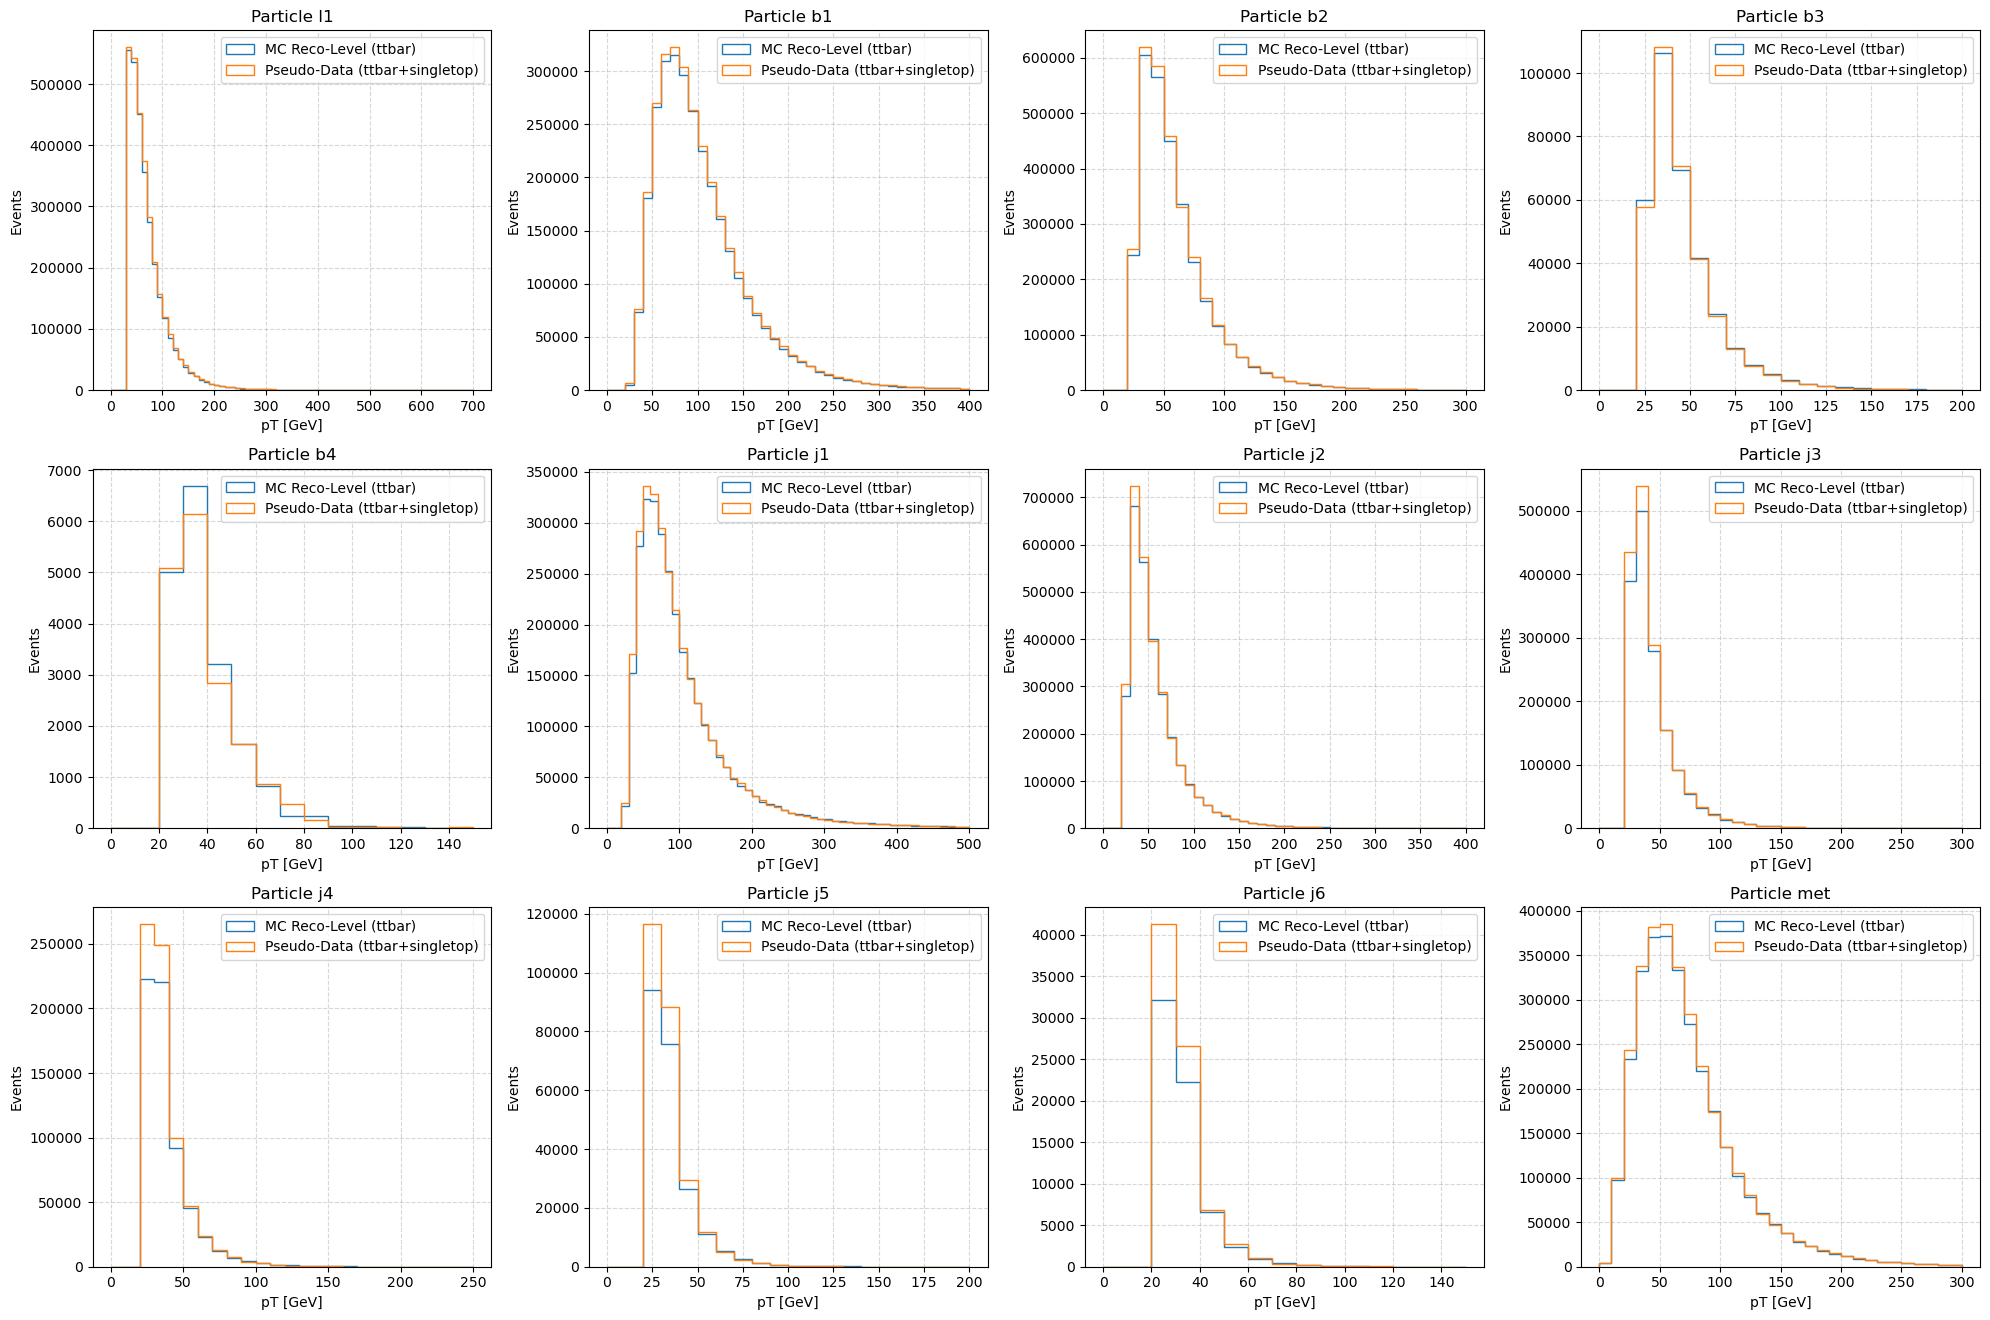

In [7]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']
pt_binning = {
    'l1': np.linspace(0, 700, 71),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
# --- Loop over all 12 particles ---
for i, pname in enumerate(particles):
    ax = axes[i]
    bins = pt_binning[pname]
    
    # masks for non-zero (non-padded) pT entries
    mask_pythia = pythia_reco_train[:, i, 0] != 0
    mask_herwig = herwig_reco[:, i, 0] != 0

    # Use .values[...] to align numpy masks with pandas Series
    ax.hist(
        pythia_reco_train[:, i, 0][mask_pythia],
        weights=(pythia_train['eventWeight'] * pythia_train['pass_particle'])[mask_pythia],
        bins=bins,
        histtype='step',
        label='MC Reco-Level (ttbar)'
    )
    ax.hist(
        herwig_reco[:, i, 0][mask_herwig],
        weights=(herwig_subset['eventWeight'] * herwig_subset['pass_particle'])[mask_herwig],
        bins=bins,
        histtype='step',
        label='Pseudo-Data (ttbar+singletop)'
    )
    
    ax.set_title(f"Particle {pname}")
    ax.legend()
    ax.set_xlabel("pT [GeV]")
    ax.set_ylabel("Events")
    ax.grid(True, linestyle='--', alpha=0.5)
    


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [8]:
class JetScaler:
    def __init__(self, mask_value=0.0):
        self.mask_value = mask_value
        self.scaler = StandardScaler()
    
    def _valid_mask(self, X):
        """
        Returns a boolean mask of jets that are *not* padding.
        Padding jets are those where all 4 features == mask_value.
        """
        return ~np.all(X == self.mask_value, axis=-1)
    
    def fit(self, X):
        """
        Fit the scaler only on valid (non-padded) jets.
        """
        X = np.array(X, dtype=float)
        valid_mask = self._valid_mask(X)
        valid_jets = X[valid_mask]
        self.scaler.fit(valid_jets)
    
    def transform(self, X):
        """
        Transform valid jets, leave padded jets at mask_value.
        """
        X = np.array(X, dtype=float)
        orig_shape = X.shape
        valid_mask = self._valid_mask(X)
        
        X_flat = X.reshape(-1, X.shape[-1])
        X_scaled = np.zeros_like(X_flat)
        
        # Only transform valid jets
        X_scaled[valid_mask.reshape(-1)] = self.scaler.transform(X_flat[valid_mask.reshape(-1)])
        
        # Keep masked jets as mask_value (usually 0)
        X_scaled[~valid_mask.reshape(-1)] = self.mask_value
        
        return X_scaled.reshape(orig_shape)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [9]:
jet_scaler = JetScaler(mask_value=0.0)
jet_scaler.fit(pythia_reco_train)
X_pythia_reco_scaled = jet_scaler.transform(pythia_reco_train)
X_pythia_truth_scaled = jet_scaler.transform(pythia_truth_train)
X_herwig_reco_scaled = jet_scaler.transform(herwig_reco)
X_herwig_truth_scaled = jet_scaler.transform(herwig_truth)

Y_truth_scaled = jet_scaler.transform(pythia_truth_test)

In [10]:
herwig_loader = DataLoader(reco = X_herwig_reco_scaled, gen = X_herwig_truth_scaled, weight = herwig_subset['eventWeight'],
                           pass_reco = herwig_subset['pass_reco'], pass_gen = herwig_subset['pass_particle'], normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled, gen = X_pythia_truth_scaled, weight = pythia_train['eventWeight'],
                           pass_reco = pythia_train['pass_reco'], pass_gen = pythia_train['pass_particle'], normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test, gen = pythia_truth_test, weight = pythia_test['eventWeight'],
                           pass_reco = pythia_test['pass_reco'], pass_gen = pythia_test['pass_particle'], normalize=False)

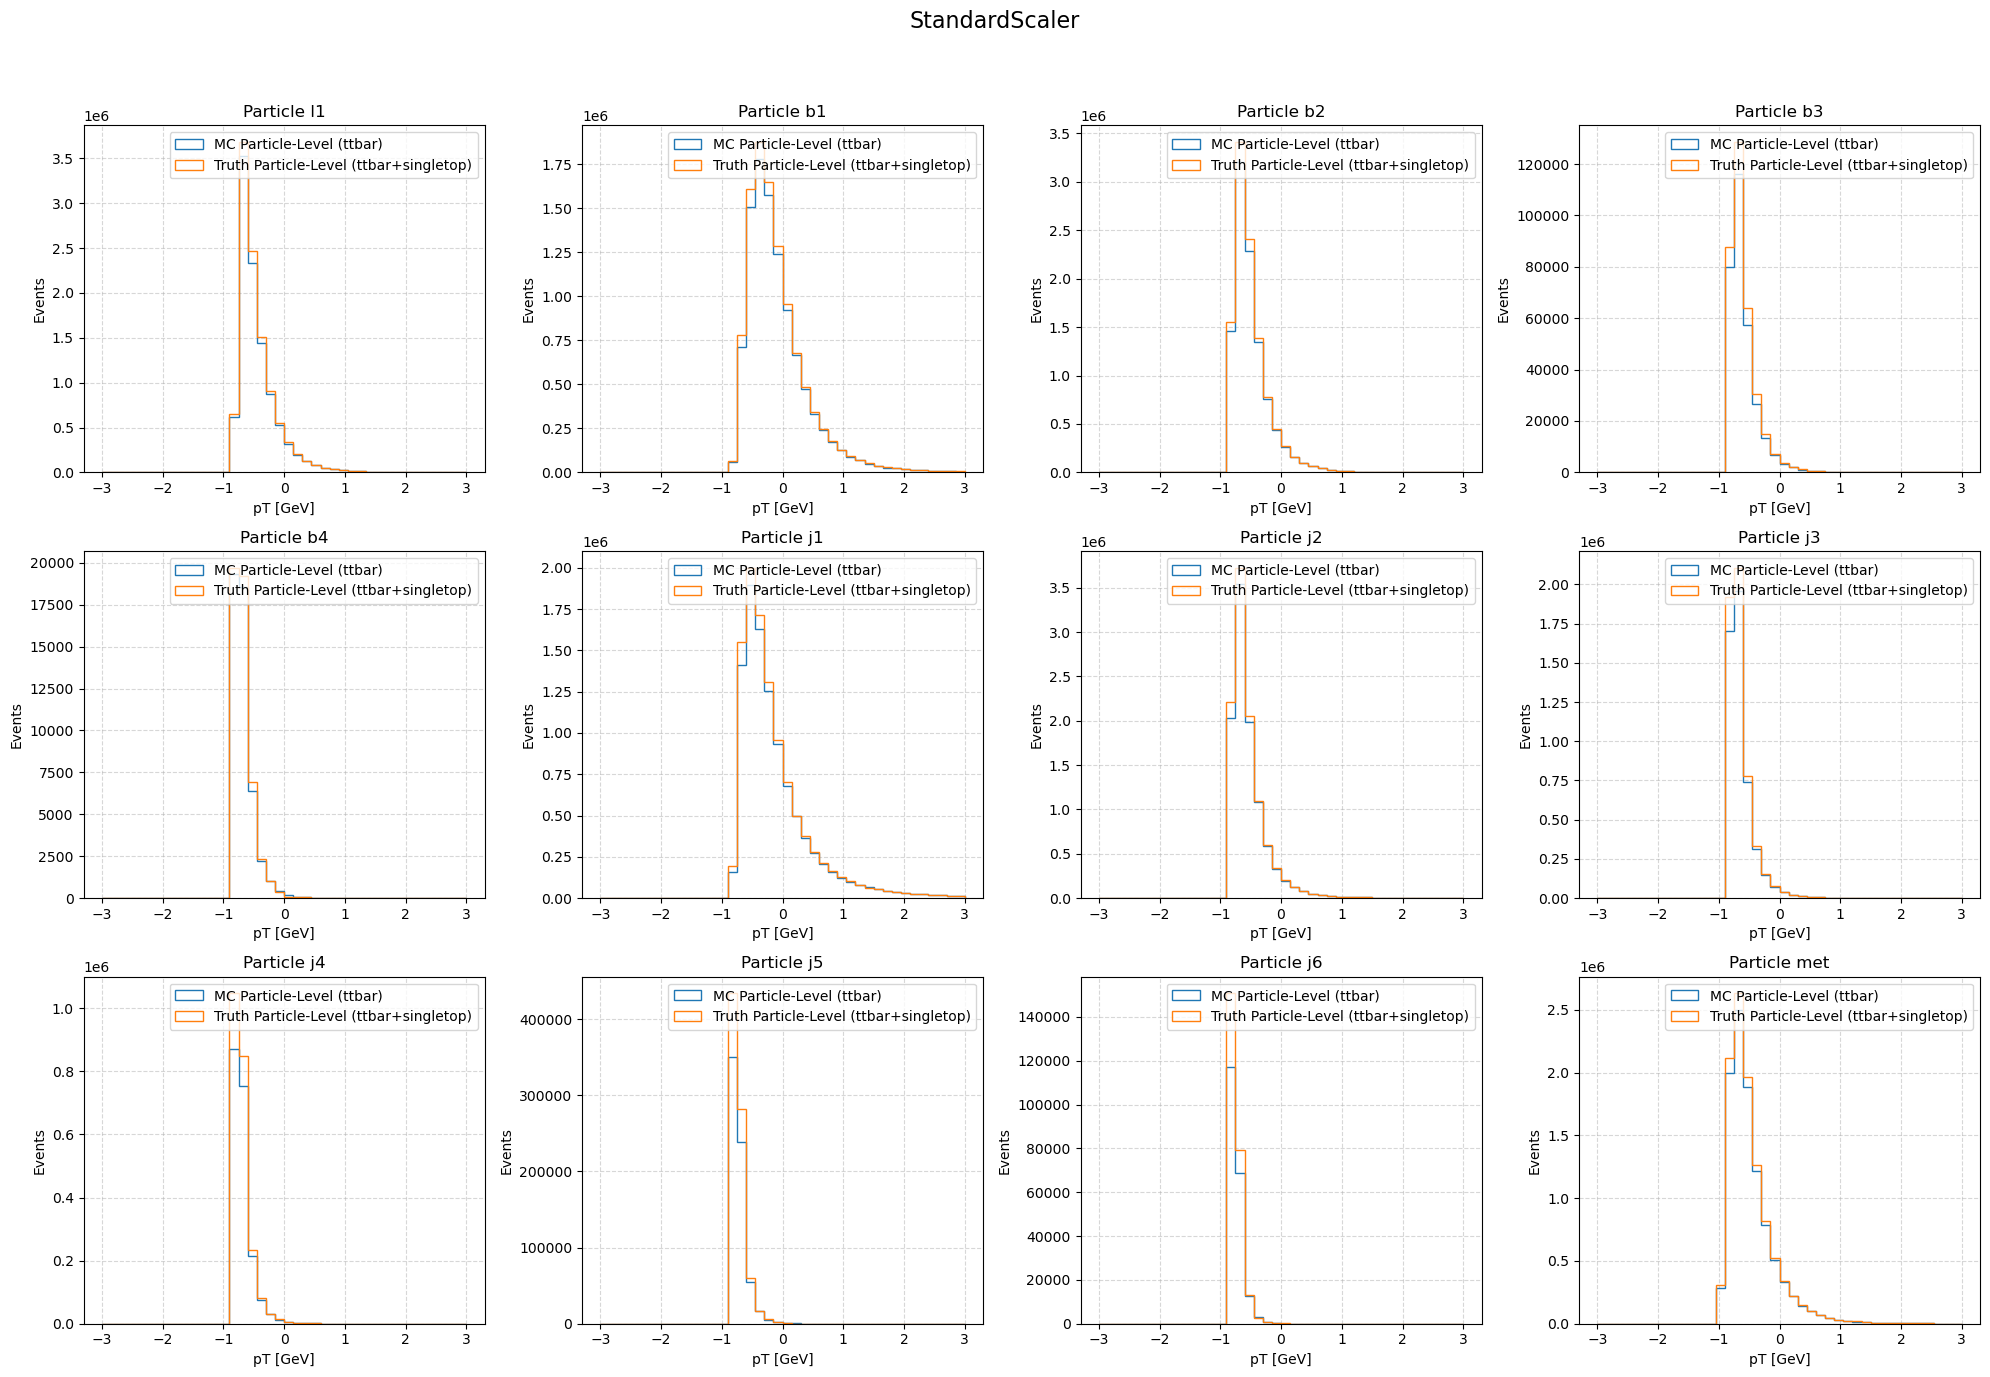

In [48]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

# --- Loop over all 12 particles ---
for i in range(len(particles)):
    ax = axes[i]
    
    # Plot pt distributions
    ax.hist(pythia_loader.gen[:, i, 0][pythia_loader.gen[:, i, 0]!=0], weights=(pythia_loader.weight*pythia_loader.pass_gen)[pythia_loader.gen[:, i, 0]!=0], bins=40, histtype='step', label='MC Particle-Level (ttbar)', range=[-3,3])
    ax.hist(herwig_loader.gen[:, i, 0][herwig_loader.gen[:, i, 0]!=0], weights=(herwig_loader.weight*herwig_loader.pass_gen)[herwig_loader.gen[:, i, 0]!=0], bins=40, histtype='step', label='Truth Particle-Level (ttbar+singletop)', range=[-3,3])
    
    ax.set_title(f"Particle {particles[i]}")
    ax.set_xlabel("pT [GeV]")
    ax.set_ylabel("Events")
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.5)
fig.suptitle("StandardScaler", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

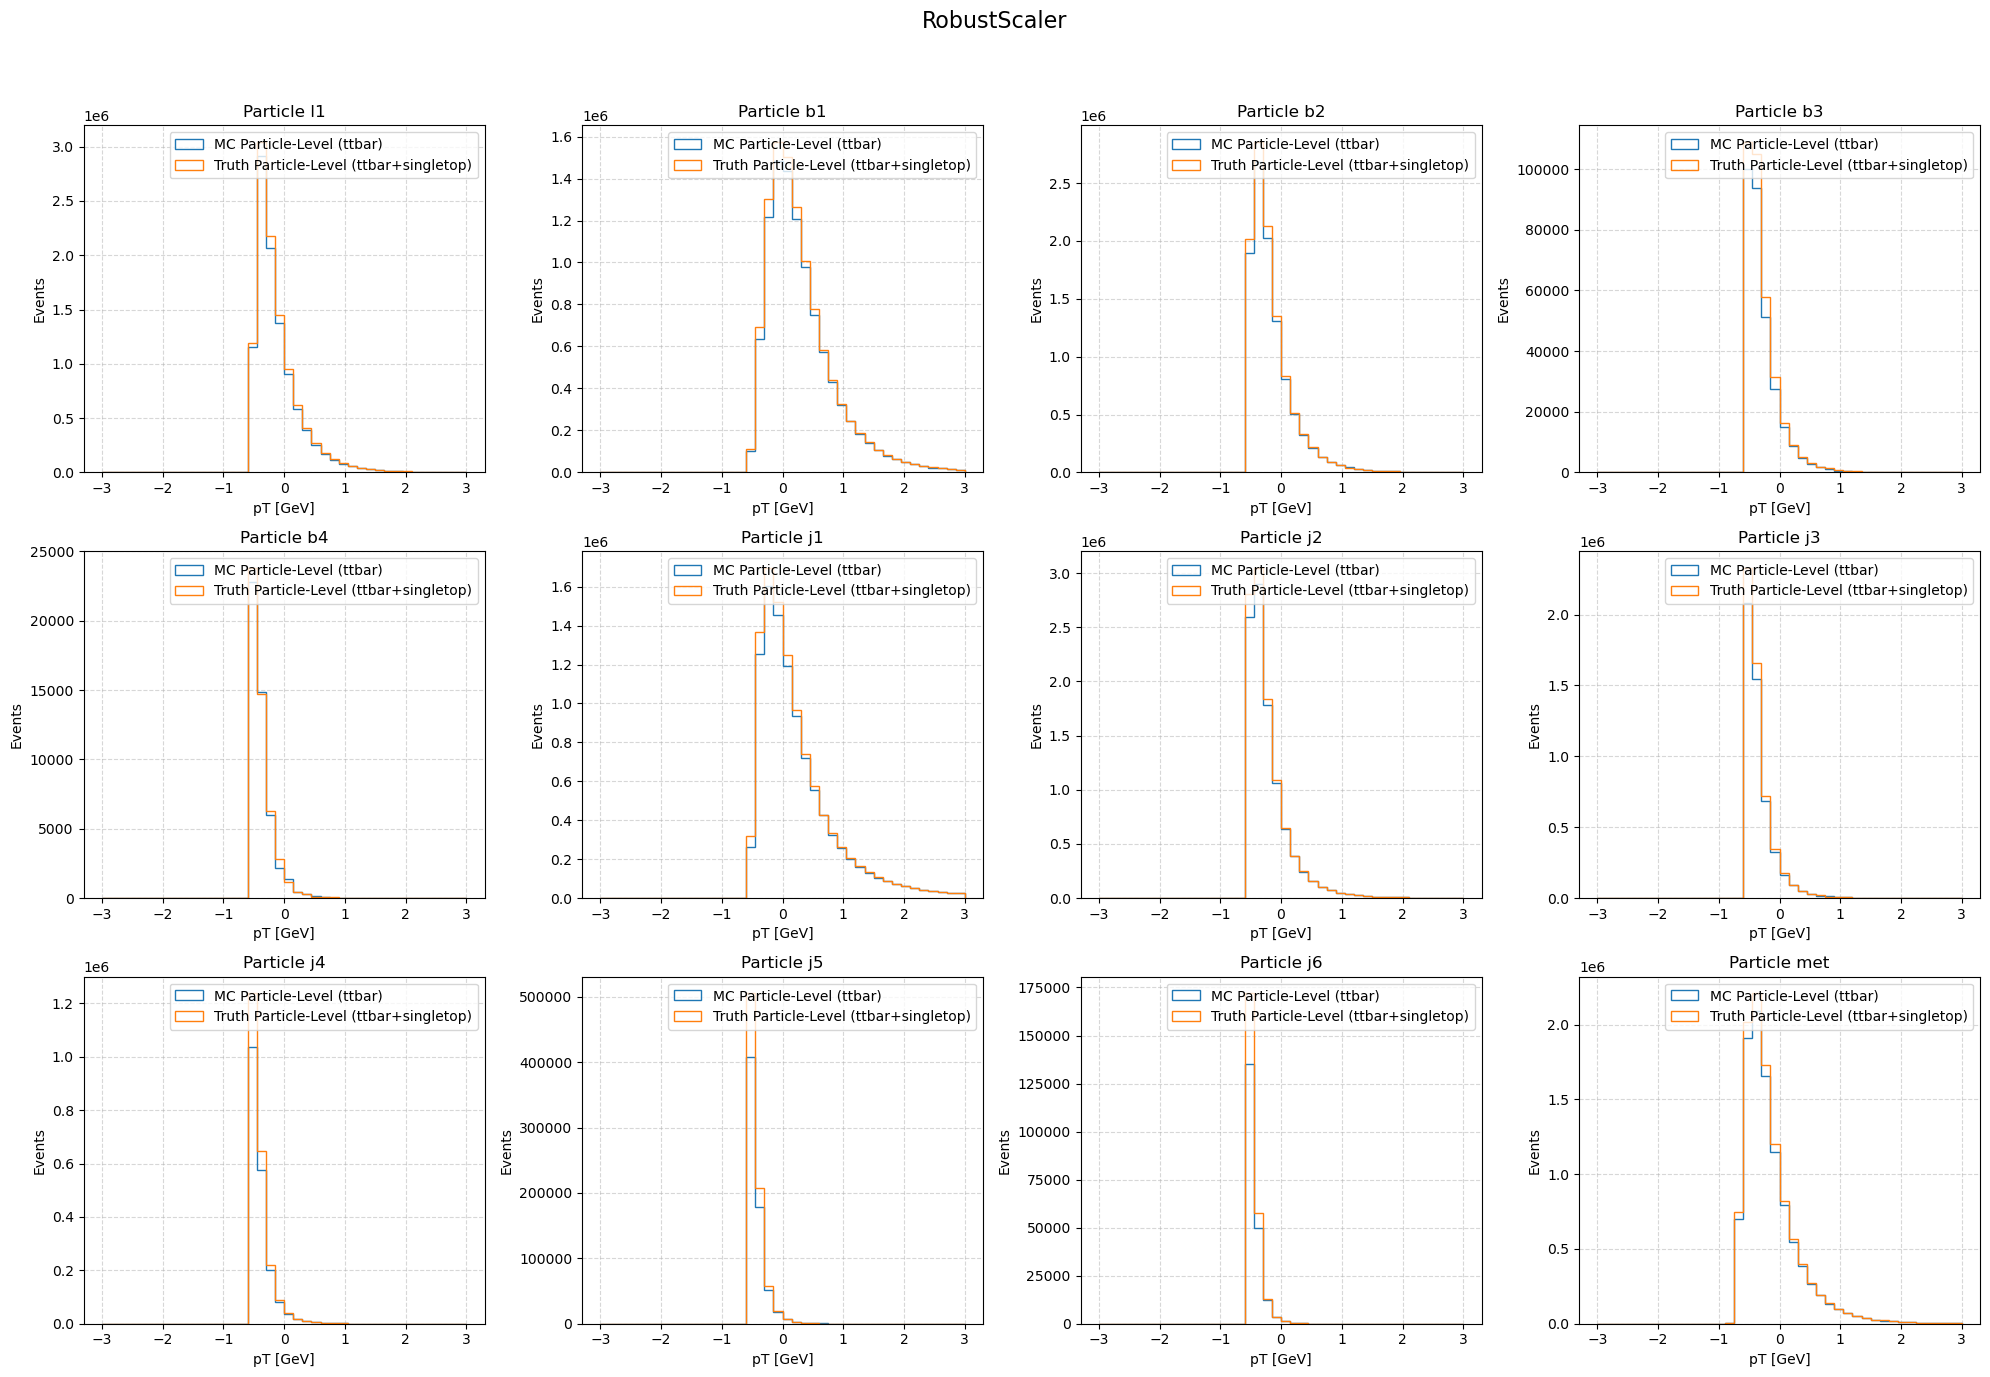

In [52]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

# --- Loop over all 12 particles ---
for i in range(len(particles)):
    ax = axes[i]
    
    # Plot pt distributions
    ax.hist(pythia_loader.gen[:, i, 0][pythia_loader.gen[:, i, 0]!=0], weights=(pythia_loader.weight*pythia_loader.pass_gen)[pythia_loader.gen[:, i, 0]!=0], bins=40, histtype='step', label='MC Particle-Level (ttbar)', range=[-3,3])
    ax.hist(herwig_loader.gen[:, i, 0][herwig_loader.gen[:, i, 0]!=0], weights=(herwig_loader.weight*herwig_loader.pass_gen)[herwig_loader.gen[:, i, 0]!=0], bins=40, histtype='step', label='Truth Particle-Level (ttbar+singletop)', range=[-3,3])
    
    ax.set_title(f"Particle {particles[i]}")
    ax.set_xlabel("pT [GeV]")
    ax.set_ylabel("Events")
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.5)
fig.suptitle("RobustScaler", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [11]:
ndim = 4 # 4 features: pt, eta, phi, mass
npart = 12 # 12 particles: l1, b1-4, j1-6, met

model1 = PET.PET(num_feat = 4, num_part = 12, local=False)
model2 = PET.PET(num_feat = 4, num_part = 12, local=False)

I0000 00:00:1762254631.217902  601991 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 139962 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:03:00.0, compute capability: 9.0


In [12]:
omnifold = test_omnifold.MultiFold(
    "closure_pythia_ttbarvsHerwig_WWbb-linear",
    model1, # model_reco
    model2, # model_gen
    herwig_loader, # data
    pythia_loader, # MC
    batch_size = 128,
    niter = 3,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_WWbb',
    verbose = True,
    early_stop=5,
    lr = 5e-6,
)

15625 training steps at reco and 15625 steps at gen


In [13]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 2000000, Test events used: 399999
################################################################################
Epoch 1/100


I0000 00:00:1762254642.849116  604636 service.cc:152] XLA service 0x7eee60002540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762254642.849165  604636 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-11-04 12:10:42.985178: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762254643.840000  604636 cuda_dnn.cc:529] Loaded cuDNN version 90501


   56/12500 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.5574 - loss: 2.9384   

I0000 00:00:1762254649.595340  604636 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.5630 - loss: 2.8230 - val_accuracy: 0.5634 - val_loss: 2.8184 - learning_rate: 5.0000e-06
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.5631 - loss: 2.8223 - val_accuracy: 0.5634 - val_loss: 2.8166 - learning_rate: 5.0000e-06
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.5632 - loss: 2.8224 - val_accuracy: 0.5634 - val_loss: 2.8136 - learning_rate: 5.0000e-06
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.5634 - loss: 2.8151 - val_accuracy: 0.5634 - val_loss: 2.8081 - learning_rate: 5.0000e-06
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.5632 - loss: 2.8039 - val_accuracy: 0.5634 - val_loss: 2.8002 - learning_rate: 5.0000e-06
Epoch 6/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.5631 - loss: 2.8061 - val_accuracy: 0.5636 - val_loss: 2.7944 - learning_rate: 5.0000e-06
Epoch 7/100
12500/12500 ━━━━━━━━━━━━━━━━

In [14]:
unfolded_weights  = omnifold.reweight(Y_truth_scaled,omnifold.model2,batch_size=1000)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [15]:
np.save("/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_WWbb/unfolded_weights-linear.npy", unfolded_weights)

In [ ]:
#unfolded_weights = np.load("/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_WWbb/unfolded_weights-linear.npy")

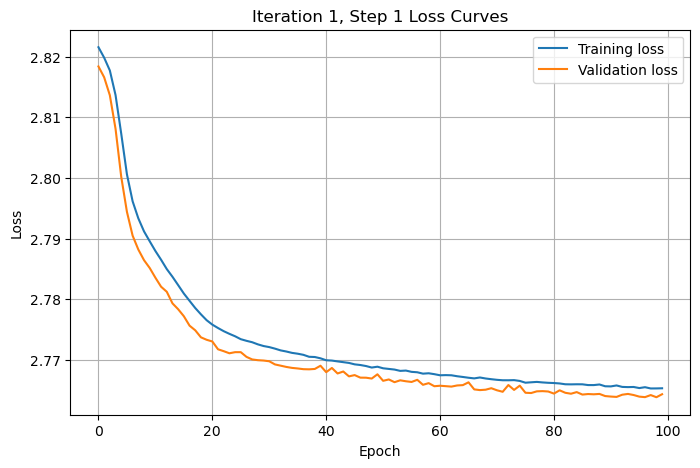

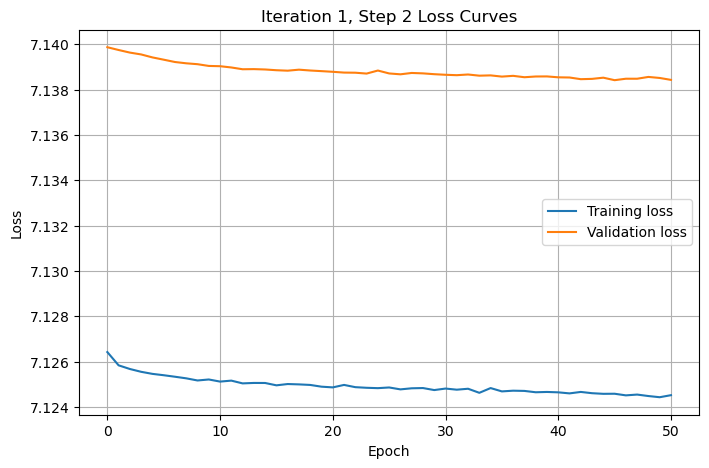

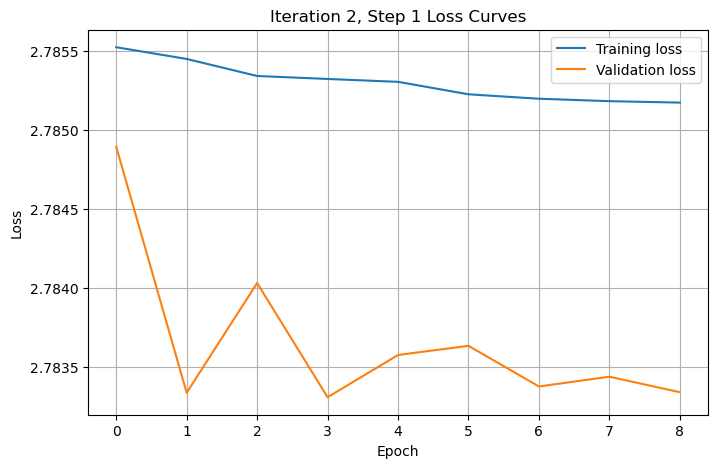

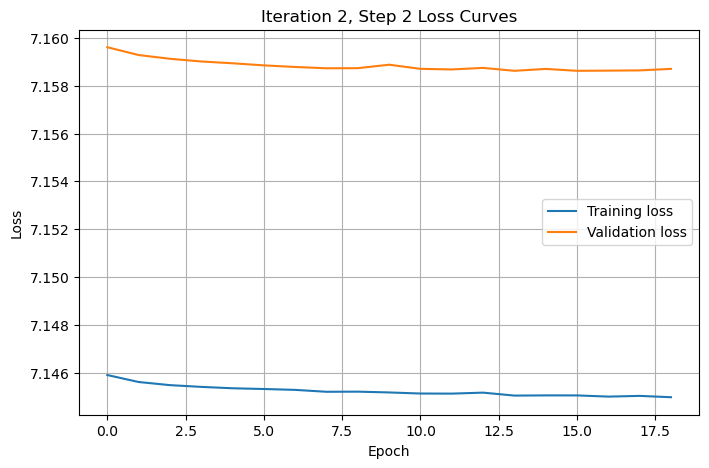

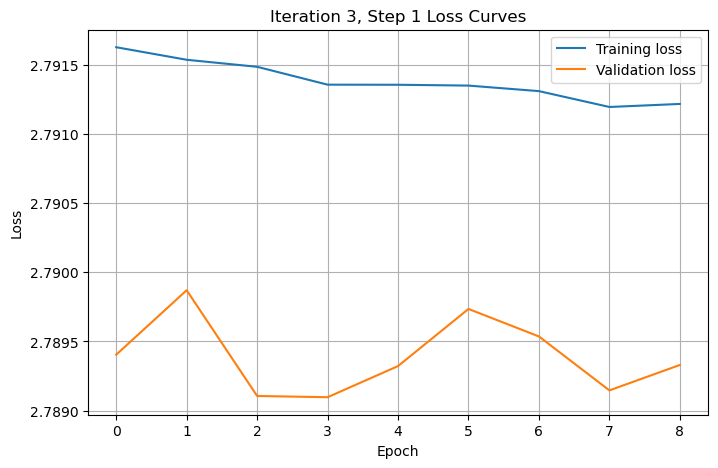

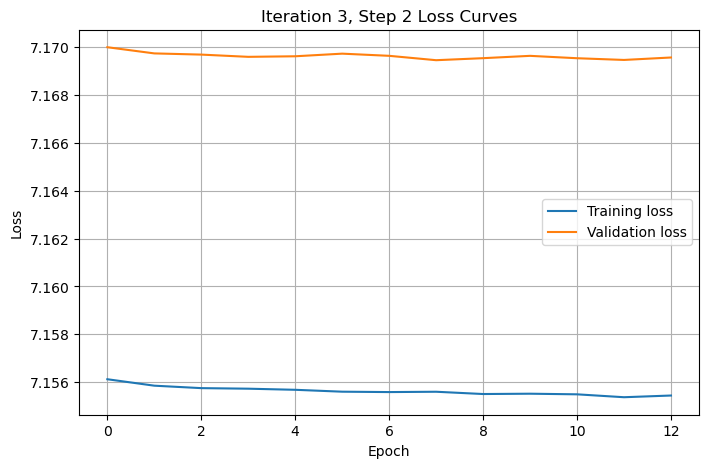

In [16]:
import pickle
import os
# Set these to your parameters
weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_WWbb'      
name = "closure_pythia_ttbarvsHerwig_WWbb-linear"    
niter = 3                       
n_ensemble = 1                  
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weights_folder}/OmniFold_{name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()


In [26]:
from omnifold import utils

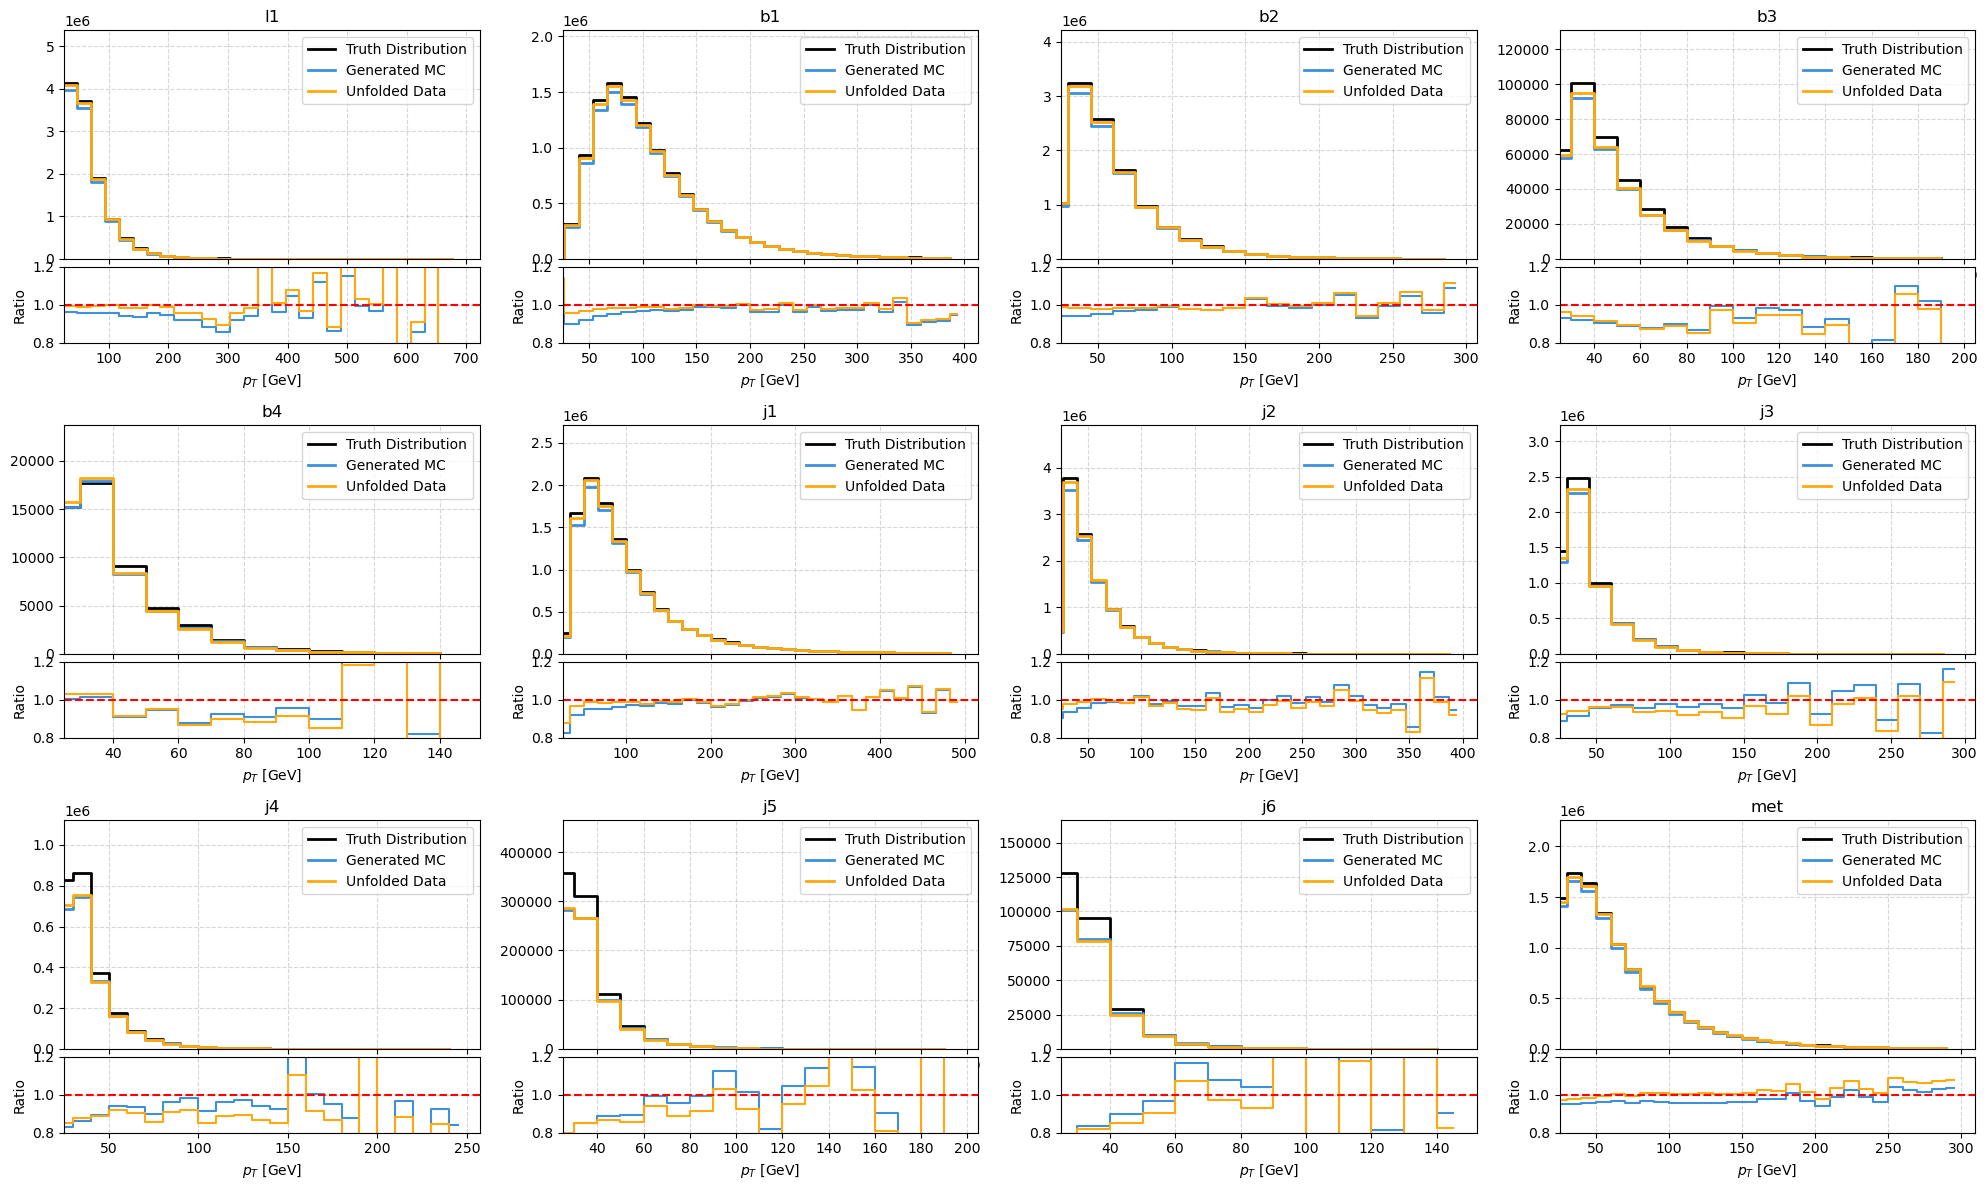

In [41]:

particles = ['l1', 'b1', 'b2', 'b3', 'b4', 
             'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(0, 700, 31),
    'b1': np.linspace(0, 400, 31),
    'b2': np.linspace(0, 300, 21),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 31),
    'j2': np.linspace(0, 400, 31),
    'j3': np.linspace(0, 300, 21),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}

# Function to plot one particle pt with ratio
def plot_pt_subplot(ax_main, ax_ratio, data_dict, weights_dict, bins):
    x_centers = 0.5 * (bins[1:] + bins[:-1])
    
    # Reference histogram: first entry
    ref_name = list(data_dict.keys())[0]
    ref_counts, _ = np.histogram(data_dict[ref_name], bins=bins, weights=weights_dict[ref_name])
    
    maxy = 0
    colors = ['black', '#3f90da', '#ffa90e', '#bd1f01']  # adjust as needed
    
    for i, (label, values) in enumerate(data_dict.items()):
        counts, _ = np.histogram(values, bins=bins, weights=weights_dict[label])
        ax_main.step(bins[:-1], counts, where='post', color=colors[i], label=label, linewidth=2)
        maxy = max(maxy, counts.max())
        
        if ax_ratio is not None and i > 0:  # skip reference
            ratio = np.divide(counts, ref_counts, out=np.zeros_like(counts), where=ref_counts!=0)
            ax_ratio.step(x_centers, ratio, where='mid', color=colors[i], label=f"{label}/{ref_name}")
    
    ax_main.set_ylim(0, 1.3*maxy)
    ax_main.set_xlim(25,)
    ax_main.grid(True, linestyle='--', alpha=0.5)
    ax_main.legend(fontsize=10)
    if ax_ratio is not None:
        ax_ratio.axhline(1.0, color='r', linestyle='--')
        ax_ratio.set_ylim(0.8, 1.2)
        ax_ratio.set_xlabel(r"$p_T$ [GeV]")
        ax_ratio.set_ylabel("Ratio")
        ax_ratio.grid(True, linestyle='--', alpha=0.5)

# --- Create figure with 3x4 subplots ---
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for i, pname in enumerate(particles[:12]):
    # Prepare data
    data_dict = {
        'Truth Distribution': herwig_truth[:, i, obs_index][herwig_truth[:, i, 0] != 0],
        'Generated MC': pythia_truth_test[:, i, obs_index][pythia_truth_test[:, i, 0] != 0],
        'Unfolded Data': pythia_truth_test[:, i, obs_index][pythia_truth_test[:, i, 0] != 0],
    }
    weight_dict = {
        'Truth Distribution': herwig_subset['eventWeight'][herwig_truth[:, i, 0] != 0],
        'Generated MC': pythia_test['eventWeight'][pythia_truth_test[:, i, 0] != 0],
        'Unfolded Data': (unfolded_weights * pythia_test['eventWeight'])[pythia_truth_test[:, i, 0] != 0],
    }
    
    # Create a small inset for ratio
    # Here we just stack main+ratio manually inside the same subplot
    # Define height ratios
    gs = axes[i].get_gridspec()
    for ax in axes[i].get_shared_x_axes().get_siblings(axes[i]):
        ax.remove()
    
    from matplotlib.gridspec import GridSpecFromSubplotSpec
    sub_gs = GridSpecFromSubplotSpec(2, 1, height_ratios=[3,1], subplot_spec=gs[i], hspace=0.05)
    ax_main = fig.add_subplot(sub_gs[0])
    ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)
    
    plot_pt_subplot(ax_main, ax_ratio, data_dict, weight_dict, pt_binning[pname])
    
    ax_main.set_title(pname)

plt.tight_layout()
plt.show()


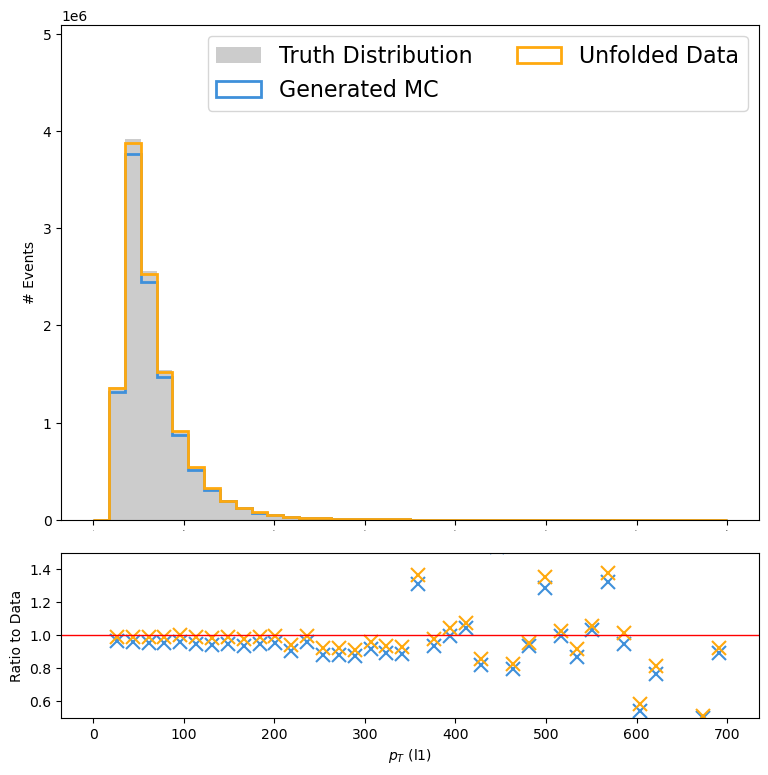

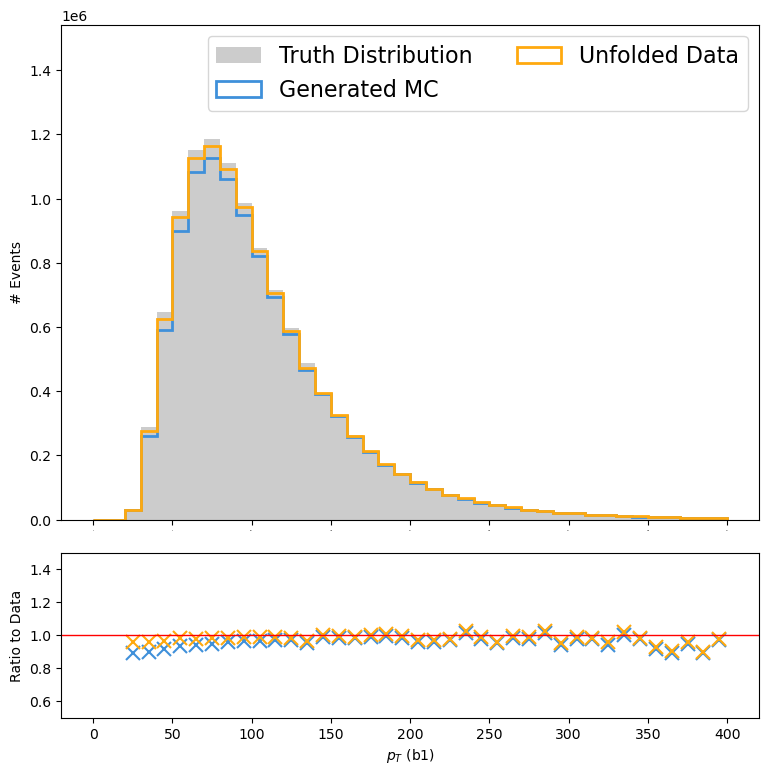

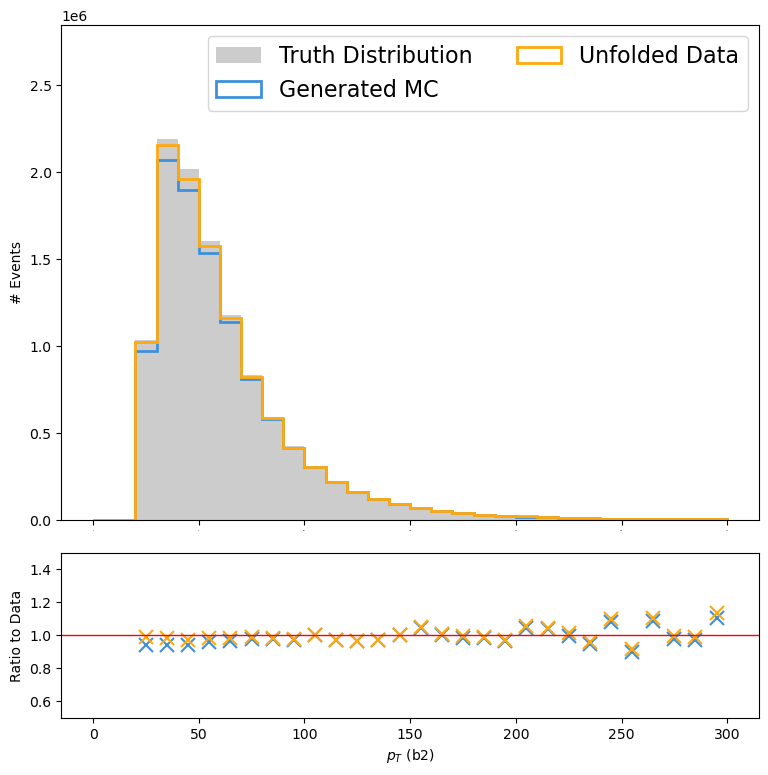

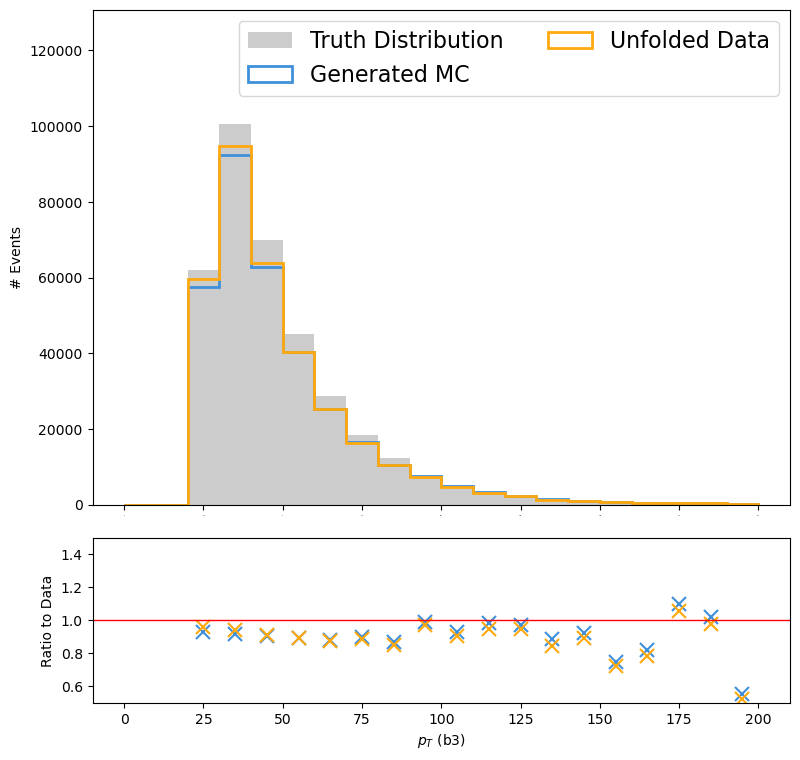

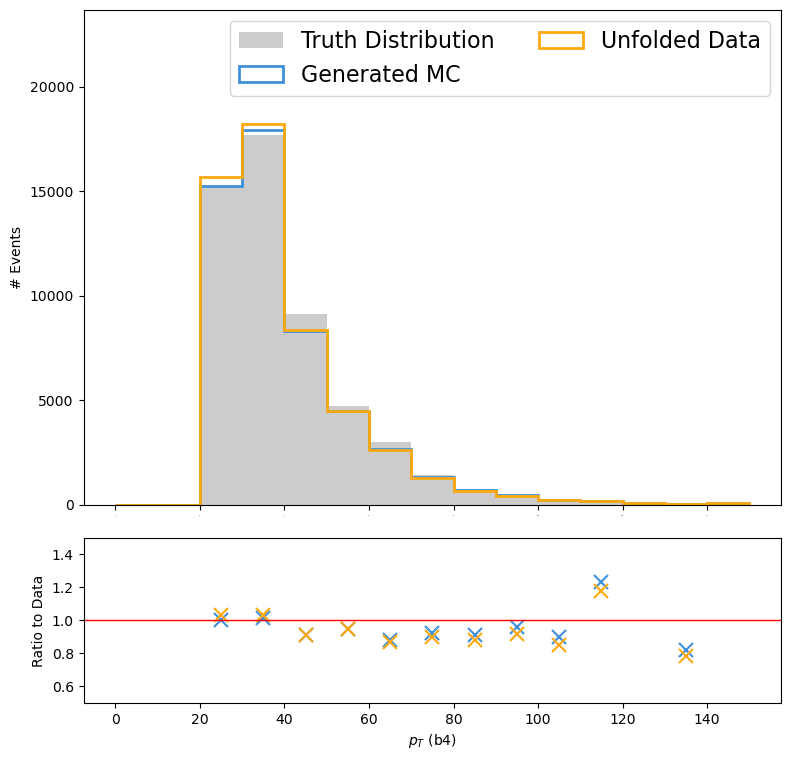

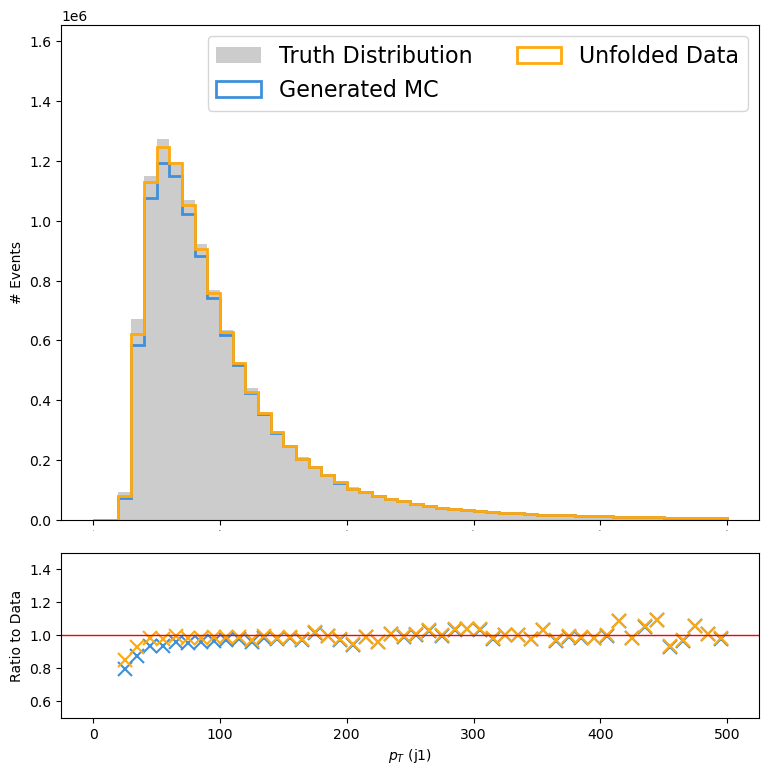

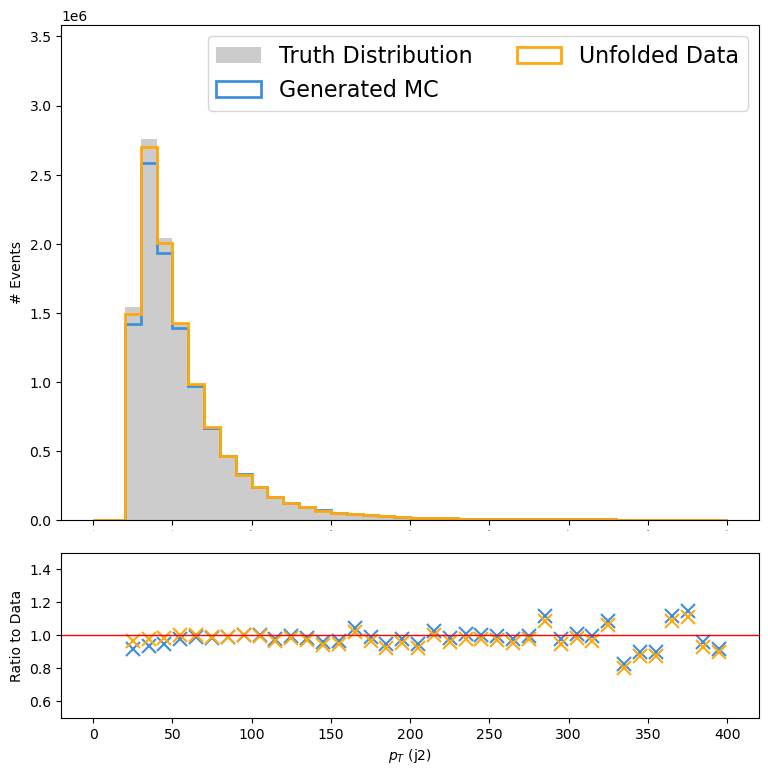

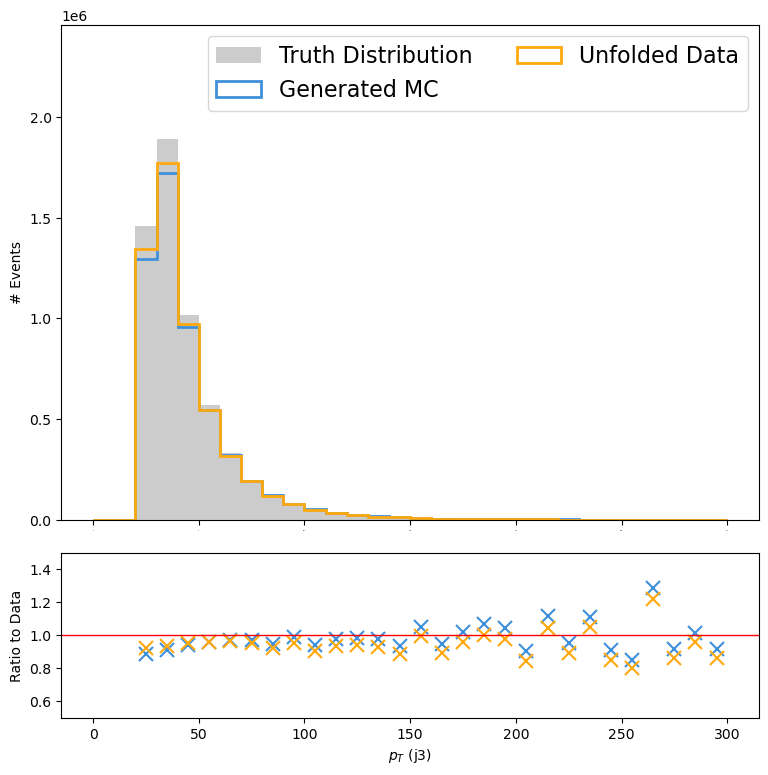

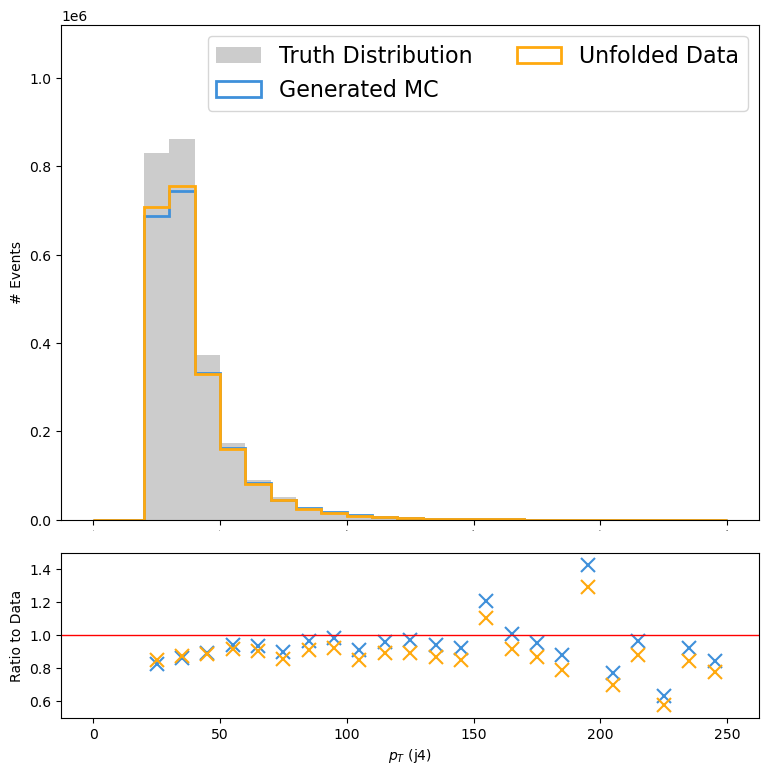

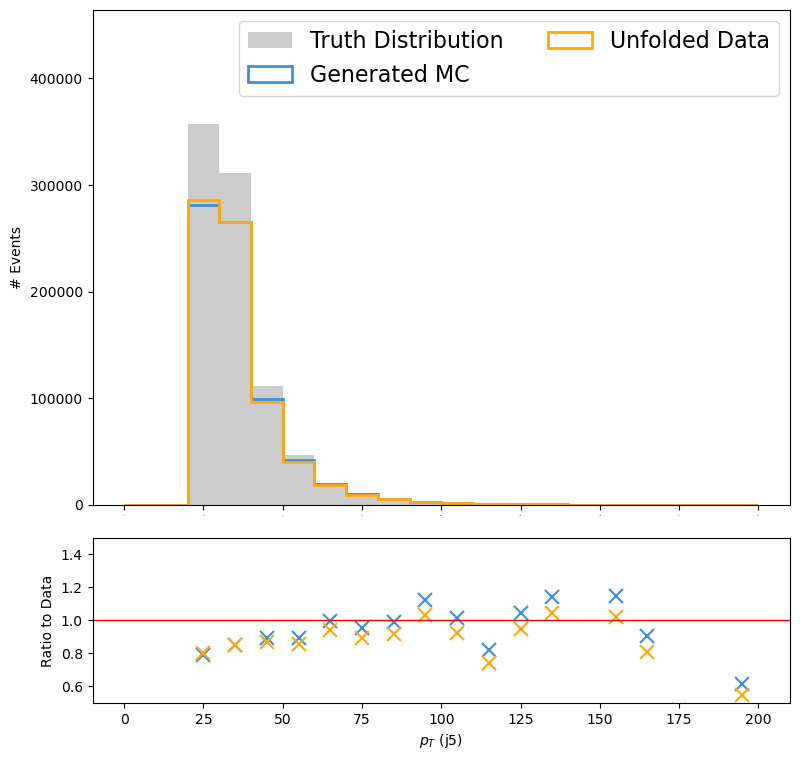

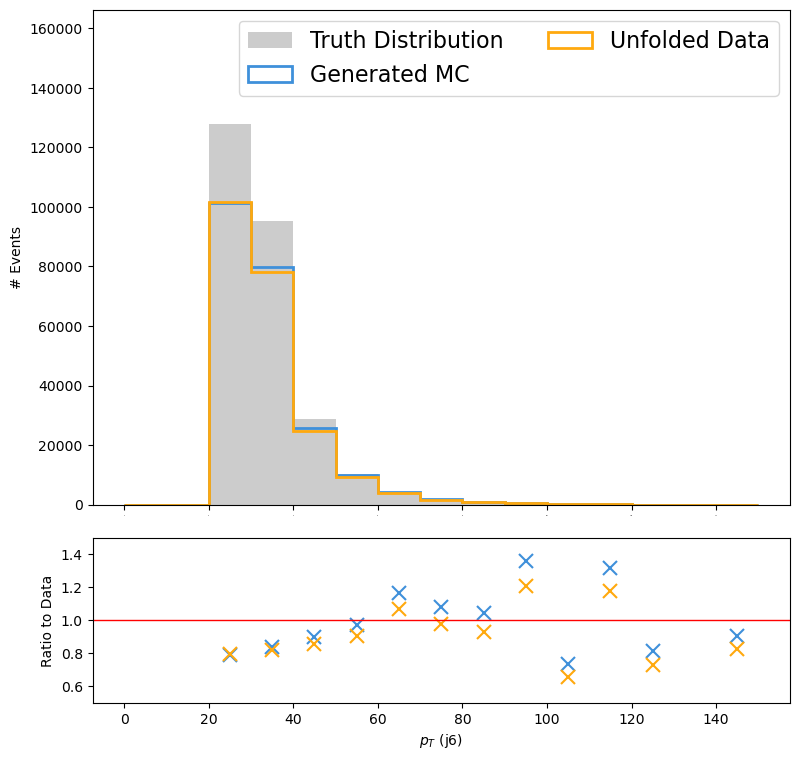

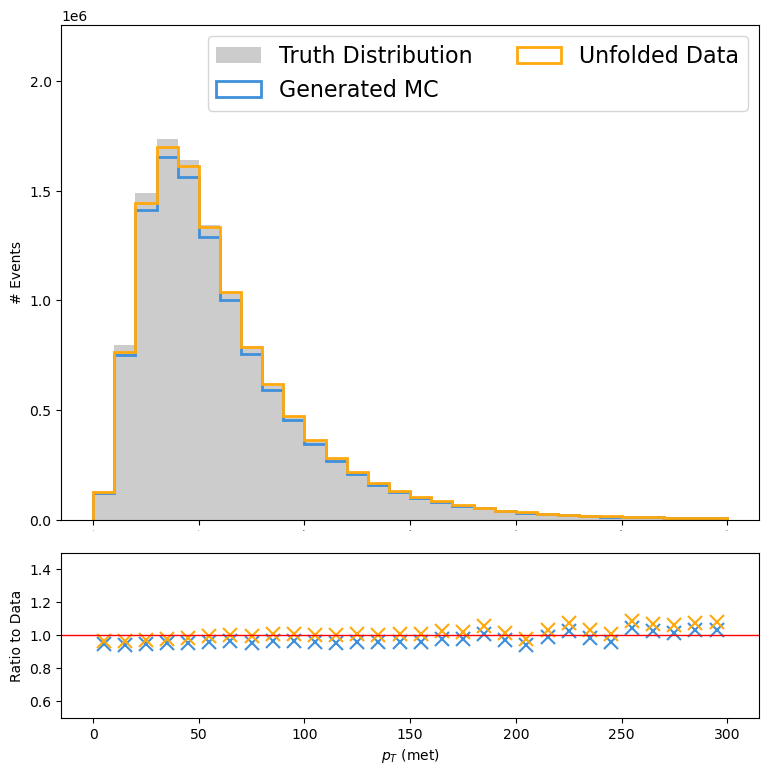

In [42]:
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(0, 700, 41),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}

for i, pname in enumerate(particles):
    ax = axes[i]

    # Only pt is plotted (obs_index = 0)
    obs_index = 0
    bins = pt_binning[pname]

    # Prepare data arrays, filtering zeros
    data_dict = {
        'Truth Distribution': herwig_truth[:, i, obs_index][herwig_truth[:, i, 0] != 0],
        'Generated MC': pythia_truth_test[:, i, obs_index][pythia_truth_test[:, i, 0] != 0],
        'Unfolded Data': pythia_truth_test[:, i, obs_index][pythia_truth_test[:, i, 0] != 0],
    }

    weight_dict = {
        'Truth Distribution': herwig_subset['eventWeight'][herwig_truth[:, i, 0] != 0],
        'Generated MC': pythia_test['eventWeight'][pythia_truth_test[:, i, 0] != 0],
        'Unfolded Data': (unfolded_weights * pythia_test['eventWeight'])[pythia_truth_test[:, i, 0] != 0],
    }

    utils.HistRoutine(
        data_dict,
        f"$p_{{T}}$ ({pname})",
        ylabel="# Events",
        reference_name='Truth Distribution',
        weights=weight_dict,
        plot_ratio=True,
        binning=bins,
    )

plt.show()


In [43]:
def convert_to4vector(array):
    """
    Convert an array of shape (n_events, n_particles, 4) with (pt, eta, phi, m)
    to an array of shape (n_events, n_particles, 4) with (E, px, py, pz).
    """
    pt = array[:, 0]
    eta = array[:, 1]
    phi = array[:, 2]
    m = array[:, 3]

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(px**2 + py**2 + pz**2 + m**2)

    return np.stack((E, px, py, pz), axis=-1)

def calculate_mass(array):
    """
    Calculate the invariant mass of the system represented by the input array.
    The input array should have shape (n_events, n_particles, 4) with (E, px, py, pz).
    Returns an array of shape (n_events,) with the invariant mass for each event.
    """
    E = array[:, 0]
    px = array[:, 1]
    py = array[:, 2]
    pz = array[:, 3]

    mass_squared = E**2 - (px**2 + py**2 + pz**2)
    mass_squared = np.maximum(mass_squared, 0)  # Avoid negative values due to numerical issues
    return np.sqrt(mass_squared)

def W_candidate(array):
    # Hard coded W mass
    W_mass = 80.379

    # leading and subleading jets (indices 5 and 6)
    leading_jet = array[:, 5, :]
    subleading_jet = array[:, 6, :]
    leading_jet_4vec = convert_to4vector(leading_jet)
    subleading_jet_4vec = convert_to4vector(subleading_jet)
    combined_4vec = leading_jet_4vec + subleading_jet_4vec

    # Calculate masses
    mass_leading = calculate_mass(leading_jet_4vec)
    mass_subleading = calculate_mass(subleading_jet_4vec)
    mass_combined = calculate_mass(combined_4vec)

    # Stack all masses and 4-vectors: shape (n_events, 3)
    all_masses = np.stack([mass_leading, mass_subleading, mass_combined], axis=1)
    all_4vecs = np.stack([leading_jet_4vec, subleading_jet_4vec, combined_4vec], axis=1)

    # Find index of mass closest to W_mass for each event
    idx_closest = np.argmin(np.abs(all_masses - W_mass), axis=1)

    # Select 4-vector for each event
    selected_4vec = all_4vecs[np.arange(len(array)), idx_closest, :]

    return selected_4vec

def min_mbl(array):
    # b-jet indices: 1, 2
    b_jets = [array[:, i, :] for i in range(1,3)]
    lepton = array[:, 0, :]

    b_jet_4vecs = [convert_to4vector(b_jet) for b_jet in b_jets]
    lepton_4vec = convert_to4vector(lepton)

    mbl_values = []
    for b_jet_4vec in b_jet_4vecs:
        combined_4vec = b_jet_4vec + lepton_4vec
        mbl = calculate_mass(combined_4vec)
        mbl_values.append(mbl)

    mbl_stack = np.stack(mbl_values, axis=1)  # shape (n_events, 2)
    return np.min(mbl_stack, axis=1)  # shape (n_events,)

def min_mbW(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    b_jet1_4vec = convert_to4vector(b_jet1)
    b_jet2_4vec = convert_to4vector(b_jet2)

    W_4vec = W_candidate(array)

    combined1_4vec = b_jet1_4vec + W_4vec
    combined2_4vec = b_jet2_4vec + W_4vec

    mbW1 = calculate_mass(combined1_4vec)
    mbW2 = calculate_mass(combined2_4vec)

    mbW_stack = np.stack([mbW1, mbW2], axis=1)  # shape (n_events, 2)
    return np.min(mbW_stack, axis=1)  # shape (n_events,)


def mbb(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    b_jet1_4vec = convert_to4vector(b_jet1)
    b_jet2_4vec = convert_to4vector(b_jet2)

    combined_4vec = b_jet1_4vec + b_jet2_4vec
    return calculate_mass(combined_4vec)

def dR2b(array):
    # b-jet indices: 1, 2
    b_jet1 = array[:, 1, :]
    b_jet2 = array[:, 2, :]

    eta1 = b_jet1[:, 1]
    phi1 = b_jet1[:, 2]
    eta2 = b_jet2[:, 1]
    phi2 = b_jet2[:, 2]

    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)

    return np.sqrt(delta_eta**2 + delta_phi**2)

(<Figure size 900x900 with 2 Axes>, <Axes: ylabel='# Events'>)

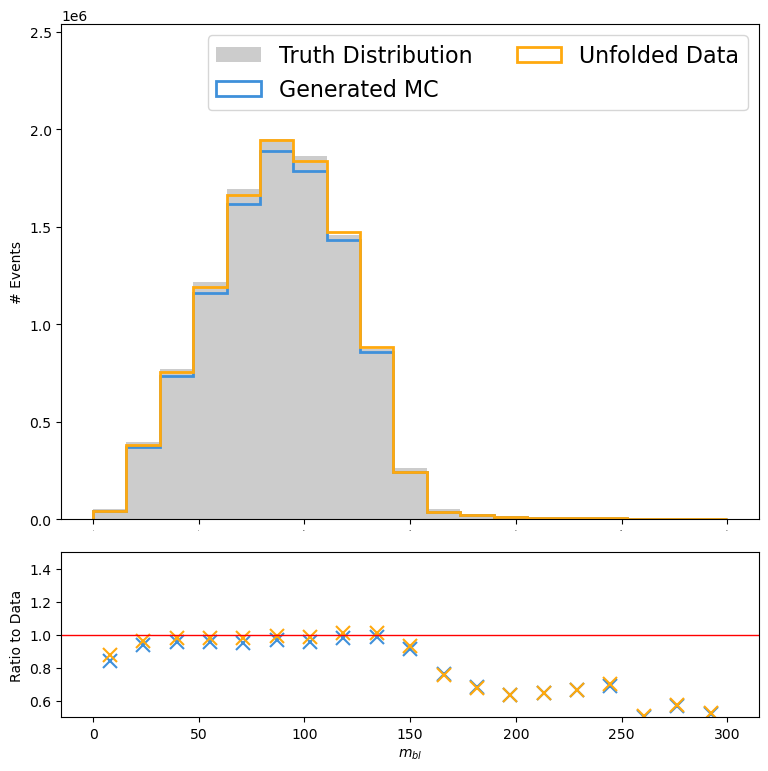

In [47]:
data_dict_mbl = {
        'Truth Distribution': min_mbl(herwig_truth),
        'Generated MC': min_mbl(pythia_truth_test),
        'Unfolded Data': min_mbl(pythia_truth_test),
    }
weight_dict_mbl = {
        'Truth Distribution': herwig_subset['eventWeight']*herwig_subset['pass_particle'],
        'Generated MC': pythia_test['eventWeight']*pythia_test['pass_particle'],
        'Unfolded Data': (unfolded_weights * pythia_test['eventWeight'])*pythia_test['pass_particle'],
    }

utils.HistRoutine(
        data_dict_mbl,
        f"$m_{{bl}}$",
        ylabel="# Events",
        reference_name='Truth Distribution',
        weights=weight_dict_mbl,
        plot_ratio=True,
        binning=np.linspace(0,300, 20),
    )